# Retrieve a CMEMS dataset - MJ Test

Imagine you used to work with this ocean colour product from CMEMS:
https://data.marine.copernicus.eu/product/OCEANCOLOUR_NWS_BGC_HR_L4_NRT_009_209/description

Now you want to move to the DTO facilities, and you are wondering how to find that dataset there. 


### 0. setup environment

#### Requirements

In [5]:
packages = ['pystac_client',
            'copernicusmarine',
            'xarray',
            'requests',
            'aiohttp',
            'copernicusmarine',
            'cartopy',
           'geopandas']

#### Install packages

In [6]:
for package in packages:
    !pip install {package} > /dev/null 2>&1

#### Load packages

In [7]:
for package in packages:
    exec(f'import {package}')

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import geopandas
import cartopy.crs as ccrs
import json
import ast
from copernicusmarine.core_functions import custom_open_zarr
from shapely.geometry import Point, box, Polygon, shape
import geopandas as gpd
from shapely import wkt

<br>

### 1. Open the STAC catalog
Using pystac client you can connect to the STAC.

In [9]:
url = 'https://catalog.dive.edito.eu'
client = pystac_client.Client.open(url)
print(client)

<Client id=root>


<br>

### 2. Load collections
One property of the STAC is collections, its a good way to explore the available datasets.

In [10]:
collections = list(client.get_collections())

Lets see how many collections there are:

In [11]:
print(f"number of collections: {len(collections)}")

number of collections: 441


<br>

### 3. Query collections
We will loop over the collections and filter a variable defined in CMEMS such as: Mass concentration of chlorophyll a in sea water. Notice that we need to add underscores as spaces are not accepted.
#### 3.1 Filter on variable

In [12]:
#variable1 = "climate_forecast-sea_water_potential_temperature_at_sea_floor" ## GLO

 ## IBI

variable1 = "ocean_mixed_layer_thickness_defined_by_sigma_theta"

If you use one of the easiest variables to obtain from the product website GLO (https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description) and IBI (https://data.marine.copernicus.eu/product/IBI_MULTIYEAR_PHY_005_002/description), then it's easier to get the zarr for the data. 

In [13]:
for collection in collections:
    if variable1 in collection.id:
        print(collection.id)

climate_forecast-ocean_mixed_layer_thickness_defined_by_sigma_theta


#### 3.2 Retrieve products
Get all the products from these collections.

In [14]:
products = []
for collection in collections:
    if variable1 in collection.id:
        for i, item in enumerate(collection.get_items()):
            products.append(item)

Lets see how many products this is.

In [15]:
print(f"number of products: {len(products)}")

number of products: 148


#### 3.3 Filter the products 
On the CMEMS webpage, the product ID is defined as "OCEANCOLOUR_NWS_BGC_HR_L4_NRT_009_209".

In [16]:
#product_id = "GLOBAL_MULTIYEAR_PHY_001_030" #GLO

product_id = "IBI_MULTIYEAR_PHY_005_002" #IBI

In [17]:
for collection in collections:
    if variable1 in collection.id:
        for i, item in enumerate(collection.get_items()):
            for asset_key, asset in item.assets.items():
                if product_id in asset.href:
                    print(i, asset.href)

4 https://s3.waw3-1.cloudferro.com/mdl-arco-geo-032/arco/IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411/geoChunked.zarr
4 https://wmts.marine.copernicus.eu/teroWmts/IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411?layer=IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411/mlotst
4 https://datalab.dive.edito.eu/data-explorer?source=https://s3.waw3-1.cloudferro.com/mdl-arco-geo-032/arco/IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411/geoChunked.zarr
5 https://s3.waw3-1.cloudferro.com/mdl-arco-time-032/arco/IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411/timeChunked.zarr
5 https://wmts.marine.copernicus.eu/teroWmts/IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411?layer=IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411/mlotst
5 https://datalab.dive.edito.eu/data-explorer?source=https://s3.waw3-1.cloudferro.com/mdl-arco-time-032/arco

<br>

### 4. Open ZARR
Select one of the zarr files and inspect how it looks. In this example we will continue with the geochunked zarr:

In [18]:
#my_zarr = "https://s3.waw3-1.cloudferro.com/mdl-arco-geo-045/arco/OCEANCOLOUR_NWS_BGC_HR_L4_NRT_009_209/cmems_obs_oc_nws_bgc_tur-spm-chl_nrt_l4-hr-mosaic_P1D-m_202107/geoChunked.zarr"

#GLO 
GLO_rean_zarr = "https://s3.waw3-1.cloudferro.com/mdl-arco-geo-025/arco/GLOBAL_MULTIYEAR_PHY_001_030/cmems_mod_glo_phy_my_0.083deg_P1M-m_202311/geoChunked.zarr"

GLO_int_zarr = "https://s3.waw3-1.cloudferro.com/mdl-arco-geo-026/arco/GLOBAL_MULTIYEAR_PHY_001_030/cmems_mod_glo_phy_myint_0.083deg_P1M-m_202311/geoChunked.zarr"

#IBI 
IBI_rean_zarr = "https://s3.waw3-1.cloudferro.com/mdl-arco-geo-032/arco/IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_my_0.083deg-3D_P1M-m_202012/geoChunked.zarr"

IBI_int_zarr = "https://s3.waw3-1.cloudferro.com/mdl-arco-geo-032/arco/IBI_MULTIYEAR_PHY_005_002/cmems_mod_ibi_phy_myint_0.083deg_P1M-m_202411/geoChunked.zarr"


In [19]:
from copernicusmarine.core_functions import custom_open_zarr

In [20]:
GLO_rean_ds = custom_open_zarr.open_zarr(GLO_rean_zarr)
GLO_int_ds = custom_open_zarr.open_zarr(GLO_int_zarr)

#print(GLO_int_ds)

Notice the size: 4TB. In CMEMS this product consists of monthly netcdf file, in ARCO format they have been merged into one file. Very handy for slicing the dataset. 

In [21]:
IBI_rean_ds = custom_open_zarr.open_zarr(IBI_rean_zarr)
IBI_int_ds = custom_open_zarr.open_zarr(IBI_int_zarr)

print(IBI_int_ds)

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 18, latitude: 361, longitude: 289, elevation: 50)
Coordinates:
  * elevation  (elevation) float32 200B -5.698e+03 -5.292e+03 ... -1.556 -0.5058
  * latitude   (latitude) float32 1kB 26.0 26.08 26.17 ... 55.83 55.92 56.0
  * longitude  (longitude) float32 1kB -19.0 -18.92 -18.83 ... 4.833 4.917 5.0
  * time       (time) datetime64[ns] 144B 2024-01-01 2024-02-01 ... 2025-06-01
Data variables:
    bottomT    (time, latitude, longitude) float64 15MB dask.array<chunksize=(8, 128, 128), meta=np.ndarray>
    mlotst     (time, latitude, longitude) float64 15MB dask.array<chunksize=(8, 128, 128), meta=np.ndarray>
    so         (time, elevation, latitude, longitude) float64 751MB dask.array<chunksize=(8, 8, 128, 128), meta=np.ndarray>
    thetao     (time, elevation, latitude, longitude) float64 751MB dask.array<chunksize=(8, 8, 128, 128), meta=np.ndarray>
    uo         (time, elevation, latitude, longitude) float64 751MB dask.array<chunksize=(8

In [22]:
IBI_int_ds['elevation']

<xarray.DataArray 'elevation' (elevation: 50)> Size: 200B
array([-5.698061e+03, -5.291683e+03, -4.888070e+03, -4.488155e+03,
       -4.093159e+03, -3.513446e+03, -3.138565e+03, -2.776039e+03,
       -2.600380e+03, -2.262422e+03, -1.945296e+03, -1.652568e+03,
       -1.387377e+03, -1.265861e+03, -1.045854e+03, -9.474479e+02,
       -7.733683e+02, -6.280260e+02, -5.652923e+02, -4.576256e+02,
       -3.706885e+02, -3.338628e+02, -2.713564e+02, -2.211412e+02,
       -1.805499e+02, -1.631645e+02, -1.330758e+02, -1.080303e+02,
       -9.704131e+01, -7.761116e+01, -6.111284e+01, -5.385064e+01,
       -4.721189e+01, -4.118002e+01, -3.574020e+01, -3.087456e+01,
       -2.655830e+01, -2.275762e+01, -1.942980e+01, -1.652532e+01,
       -1.399104e+01, -1.177368e+01, -9.822750e+00, -8.092519e+00,
       -6.543034e+00, -5.140361e+00, -3.856280e+00, -2.667682e+00,
       -1.555855e+00, -5.057600e-01], dtype=float32)
Coordinates:
  * elevation  (elevation) float32 200B -5.698e+03 -5.292e+03 ... -1.556 -0.5058
Attributes:
    axis:           Z
    long_name:      Elevation
    positive:       up
    standard_name:  elevation
    unit_long:      Meters
    units:          m

<br>

### 5. Slice data and plot
Slice the dataset based on extend in space and time.

In [29]:
lat_min, lat_max = (37, 41.4) 
lon_min, lon_max = (-14, -8.6)
depth_min, depth_max = (-1050, -950) #IBI
depth_min1, depth_max1 = (-1000, -900) #GLO

time_index = 0

Execute the slicing.

In [43]:
#Temp
GLO_temp_rean_subset = GLO_rean_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min1, depth_max1))['thetao']
IBI_temp_rean_subset = IBI_rean_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min, depth_max))['thetao']

GLO_temp_int_subset = GLO_int_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min1, depth_max1))['thetao']
IBI_temp_int_subset = IBI_int_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min, depth_max))['thetao']

#Sal

GLO_sal_rean_subset = GLO_rean_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min1, depth_max1))['so']
IBI_sal_rean_subset = IBI_rean_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min, depth_max))['so']

GLO_sal_int_subset = GLO_int_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min1, depth_max1))['so']
IBI_sal_int_subset = IBI_int_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), elevation=slice(depth_min, depth_max))['so']


In [45]:
#Temp
GLO_temp_rean_subset1 = np.mean(GLO_temp_rean_subset, axis = (1,2,3))
IBI_temp_rean_subset1 = np.mean(IBI_temp_rean_subset, axis = (1,2,3))

GLO_temp_int_subset1 = np.mean(GLO_temp_int_subset, axis = (1,2,3))
IBI_temp_int_subset1 = np.mean(IBI_temp_int_subset, axis = (1,2,3))

#Sal
GLO_sal_rean_subset1 = np.mean(GLO_sal_rean_subset, axis = (1,2,3))
IBI_sal_rean_subset1 = np.mean(IBI_sal_rean_subset, axis = (1,2,3))

GLO_sal_int_subset1 = np.mean(GLO_sal_int_subset, axis = (1,2,3))
IBI_sal_int_subset1 = np.mean(IBI_sal_int_subset, axis = (1,2,3))


In [51]:
fig = plt.figure(figsize=[22,24])
fig.suptitle("MOW Reservoir Monthly Reanalysis Data", fontsize = 28, y = 0.92)

ax1 = fig.add_subplot(2,1,1)
ax1.plot(GLO_int_ds['time'],GLO_sal_int_subset1, color = 'b', label = 'GLO')
ax1.plot(IBI_int_ds['time'],IBI_sal_int_subset1, color = 'orange', label = 'IBI')
ax1.plot(GLO_rean_ds['time'],GLO_sal_rean_subset1, color = 'b')
ax1.plot(IBI_rean_ds['time'],IBI_sal_rean_subset1, color = 'orange')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax1.set_title('Mean Salinity', fontsize = 20)
ax1.set_ylabel("Salinity [PSU])", color= 'k', fontsize=16)
ax1.legend(loc=2, prop={'size': 15})

ax1 = fig.add_subplot(2,1,2)
ax1.plot(GLO_int_ds['time'],GLO_temp_int_subset1, color = 'b', label = 'GLO')
ax1.plot(IBI_int_ds['time'],IBI_temp_int_subset1, color = 'orange', label = 'IBI')
ax1.plot(GLO_rean_ds['time'],GLO_temp_rean_subset1, color = 'b')
ax1.plot(IBI_rean_ds['time'],IBI_temp_rean_subset1, color = 'orange')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax1.set_title('Mean Temperature', fontsize = 20)
ax1.set_ylabel("Temperature [ºC])", color= 'k', fontsize=16)
#ax1.legend(loc=2, prop={'size': 15})

plt.show()

#plt.savefig('./Reanal.png', format = 'png', dpi = 300)
#plt.close()

Import parquet files from Beacon work from before... (ideally you should connect EDITO to Blue Cloud but for the sake of testing...)

In [53]:
#%pip install pyarrow
CORA_df = pd.read_parquet('CORA_PR_MOW_Reservoir_1950_2024(1).parquet')

SDN_df = pd.read_parquet('SEADATANET_MOW_Reservoir_1950_2024.parquet')

WOD_df = pd.read_parquet('WOD_MOW_Reservoir_1950_2024.parquet')

ARGO_df = pd.read_parquet('ARGO_MOW_Reservoir_1950_2024.parquet')

EMOD_df = pd.read_parquet('EMOD_MOW_Reservoir_1950_2024.parquet')

In [54]:
CORA_df = CORA_df[CORA_df['TEMPERATURE_QC']==1]
CORA_df = CORA_df[CORA_df['SALINITY_QC']==1]

SDN_df = SDN_df[SDN_df['TEMPERATURE_QC']==49]
SDN_df = SDN_df[SDN_df['SALINITY_QC']==49]
SDN_df = SDN_df[SDN_df["SALINITY"]>35.6]

In [57]:
parameter1 = "TEMPERATURE"
parameter2 = "SALINITY" 
parameter3 = "OXYGEN" 

regionname = "MOW Reservoir"

mindate = "1950-01-01" #yyyy-mm-dd
maxdate = "2024-12-31" #yyyy-mm-dd
minlon = -14
maxlon = -8.6
minlat = 37
maxlat = 41.4
mindepth = 995
maxdepth = 1005

In [59]:
## New dataframes for averaging purposes

CORA_df2 = pd.DataFrame({'date':CORA_df['TIME'],'date2':CORA_df['TIME'],'temp':CORA_df['TEMPERATURE'][CORA_df['TEMPERATURE_QC'] == 1],'sal':CORA_df['SALINITY'][CORA_df['SALINITY_QC'] == 1]})
SDN_df2 = pd.DataFrame({'date':SDN_df['TIME'],'date2':SDN_df['TIME'],'temp':SDN_df['TEMPERATURE'][SDN_df['TEMPERATURE_QC'] == 49],'sal':SDN_df['SALINITY'][SDN_df['SALINITY_QC'] == 49]})
WOD_df2 = pd.DataFrame({'date':WOD_df['TIME'],'date2':WOD_df['TIME'],'temp':WOD_df['TEMPERATURE'][WOD_df['TEMPERATURE_QC'] == 0],'sal':WOD_df['SALINITY'][WOD_df['SALINITY_QC'] == 0]})
ARGO_df2 = pd.DataFrame({'date':ARGO_df['TIME'],'date2':ARGO_df['TIME'],'temp':ARGO_df['TEMPERATURE'],'sal':ARGO_df['SALINITY']})
EMOD_df2 = pd.DataFrame({'date':EMOD_df['time'],'date2':EMOD_df['time'],'o2':EMOD_df['OXYGEN']})

In [62]:
CORA_df2#Monthly Means
CORA_month = CORA_df2.dropna().resample('ME', on='date').mean()
SDN_month =SDN_df2.dropna().resample('ME', on='date').mean()
WOD_month =WOD_df2.dropna().resample('ME', on='date').mean()
ARGO_month =ARGO_df2.dropna().resample('ME', on='date').mean()
EMOD_month =EMOD_df2.dropna().resample('ME', on='date').mean()

#Yearly Means
CORA_year = CORA_df2.dropna().resample('YE', on='date').mean()
SDN_year =SDN_df2.dropna().resample('YE', on='date').mean()
WOD_year =WOD_df2.dropna().resample('YE', on='date').mean()
ARGO_year =ARGO_df2.dropna().resample('YE', on='date').mean()
EMOD_year =EMOD_df2.dropna().resample('YE', on='date').mean()

#Monthly Maxes
CORA_month_max = CORA_df2.dropna().resample('ME', on='date').max()
SDN_month_max =SDN_df2.dropna().resample('ME', on='date').max()
WOD_month_max =WOD_df2.dropna().resample('ME', on='date').max()
ARGO_month_max =ARGO_df2.dropna().resample('ME', on='date').max()
EMOD_month_max =EMOD_df2.dropna().resample('ME', on='date').max()

#Yearly Maxes
CORA_year_max = CORA_df2.dropna().resample('YE', on='date').max()
SDN_year_max =SDN_df2.dropna().resample('YE', on='date').max()
WOD_year_max =WOD_df2.dropna().resample('YE', on='date').max()
ARGO_year_max =ARGO_df2.dropna().resample('YE', on='date').max()
EMOD_year_max =EMOD_df2.dropna().resample('YE', on='date').max()

#Monthly Mins
CORA_month_min = CORA_df2.dropna().resample('ME', on='date').min()
SDN_month_min =SDN_df2.dropna().resample('ME', on='date').min()
WOD_month_min =WOD_df2.dropna().resample('ME', on='date').min()
ARGO_month_min =ARGO_df2.dropna().resample('ME', on='date').min()
EMOD_month_min =EMOD_df2.dropna().resample('ME', on='date').min()

#Yearly Mins
CORA_year_min = CORA_df2.dropna().resample('YE', on='date').min()
SDN_year_min =SDN_df2.dropna().resample('YE', on='date').min()
WOD_year_min =WOD_df2.dropna().resample('YE', on='date').min()
ARGO_year_min =ARGO_df2.dropna().resample('YE', on='date').min()
EMOD_year_min =EMOD_df2.dropna().resample('YE', on='date').min()

In [63]:
CORA_year

,date2,temp,sal
date,,,
1957-12-31,1957-10-29 03:18:00.000,12.399000,36.509003
1958-12-31,1958-07-04 06:21:25.715,10.822572,36.082928
1959-12-31,NaT,NaN,NaN
1960-12-31,NaT,NaN,NaN
1961-12-31,NaT,NaN,NaN
...,...,...,...
2019-12-31,2019-05-23 14:10:40.895,10.942209,36.080658
2020-12-31,2020-06-17 08:30:06.362,11.150330,36.151978
2021-12-31,2021-05-08 03:40:59.521,11.204638,36.186504


In [66]:
cora_m_time = np.array(CORA_month['date2'])
sdn_m_time = np.array(SDN_month['date2'])
wod_m_time = np.array(WOD_month['date2'])
argo_m_time = np.array(ARGO_month['date2'])
emod_m_time = np.array(EMOD_month['date2'])

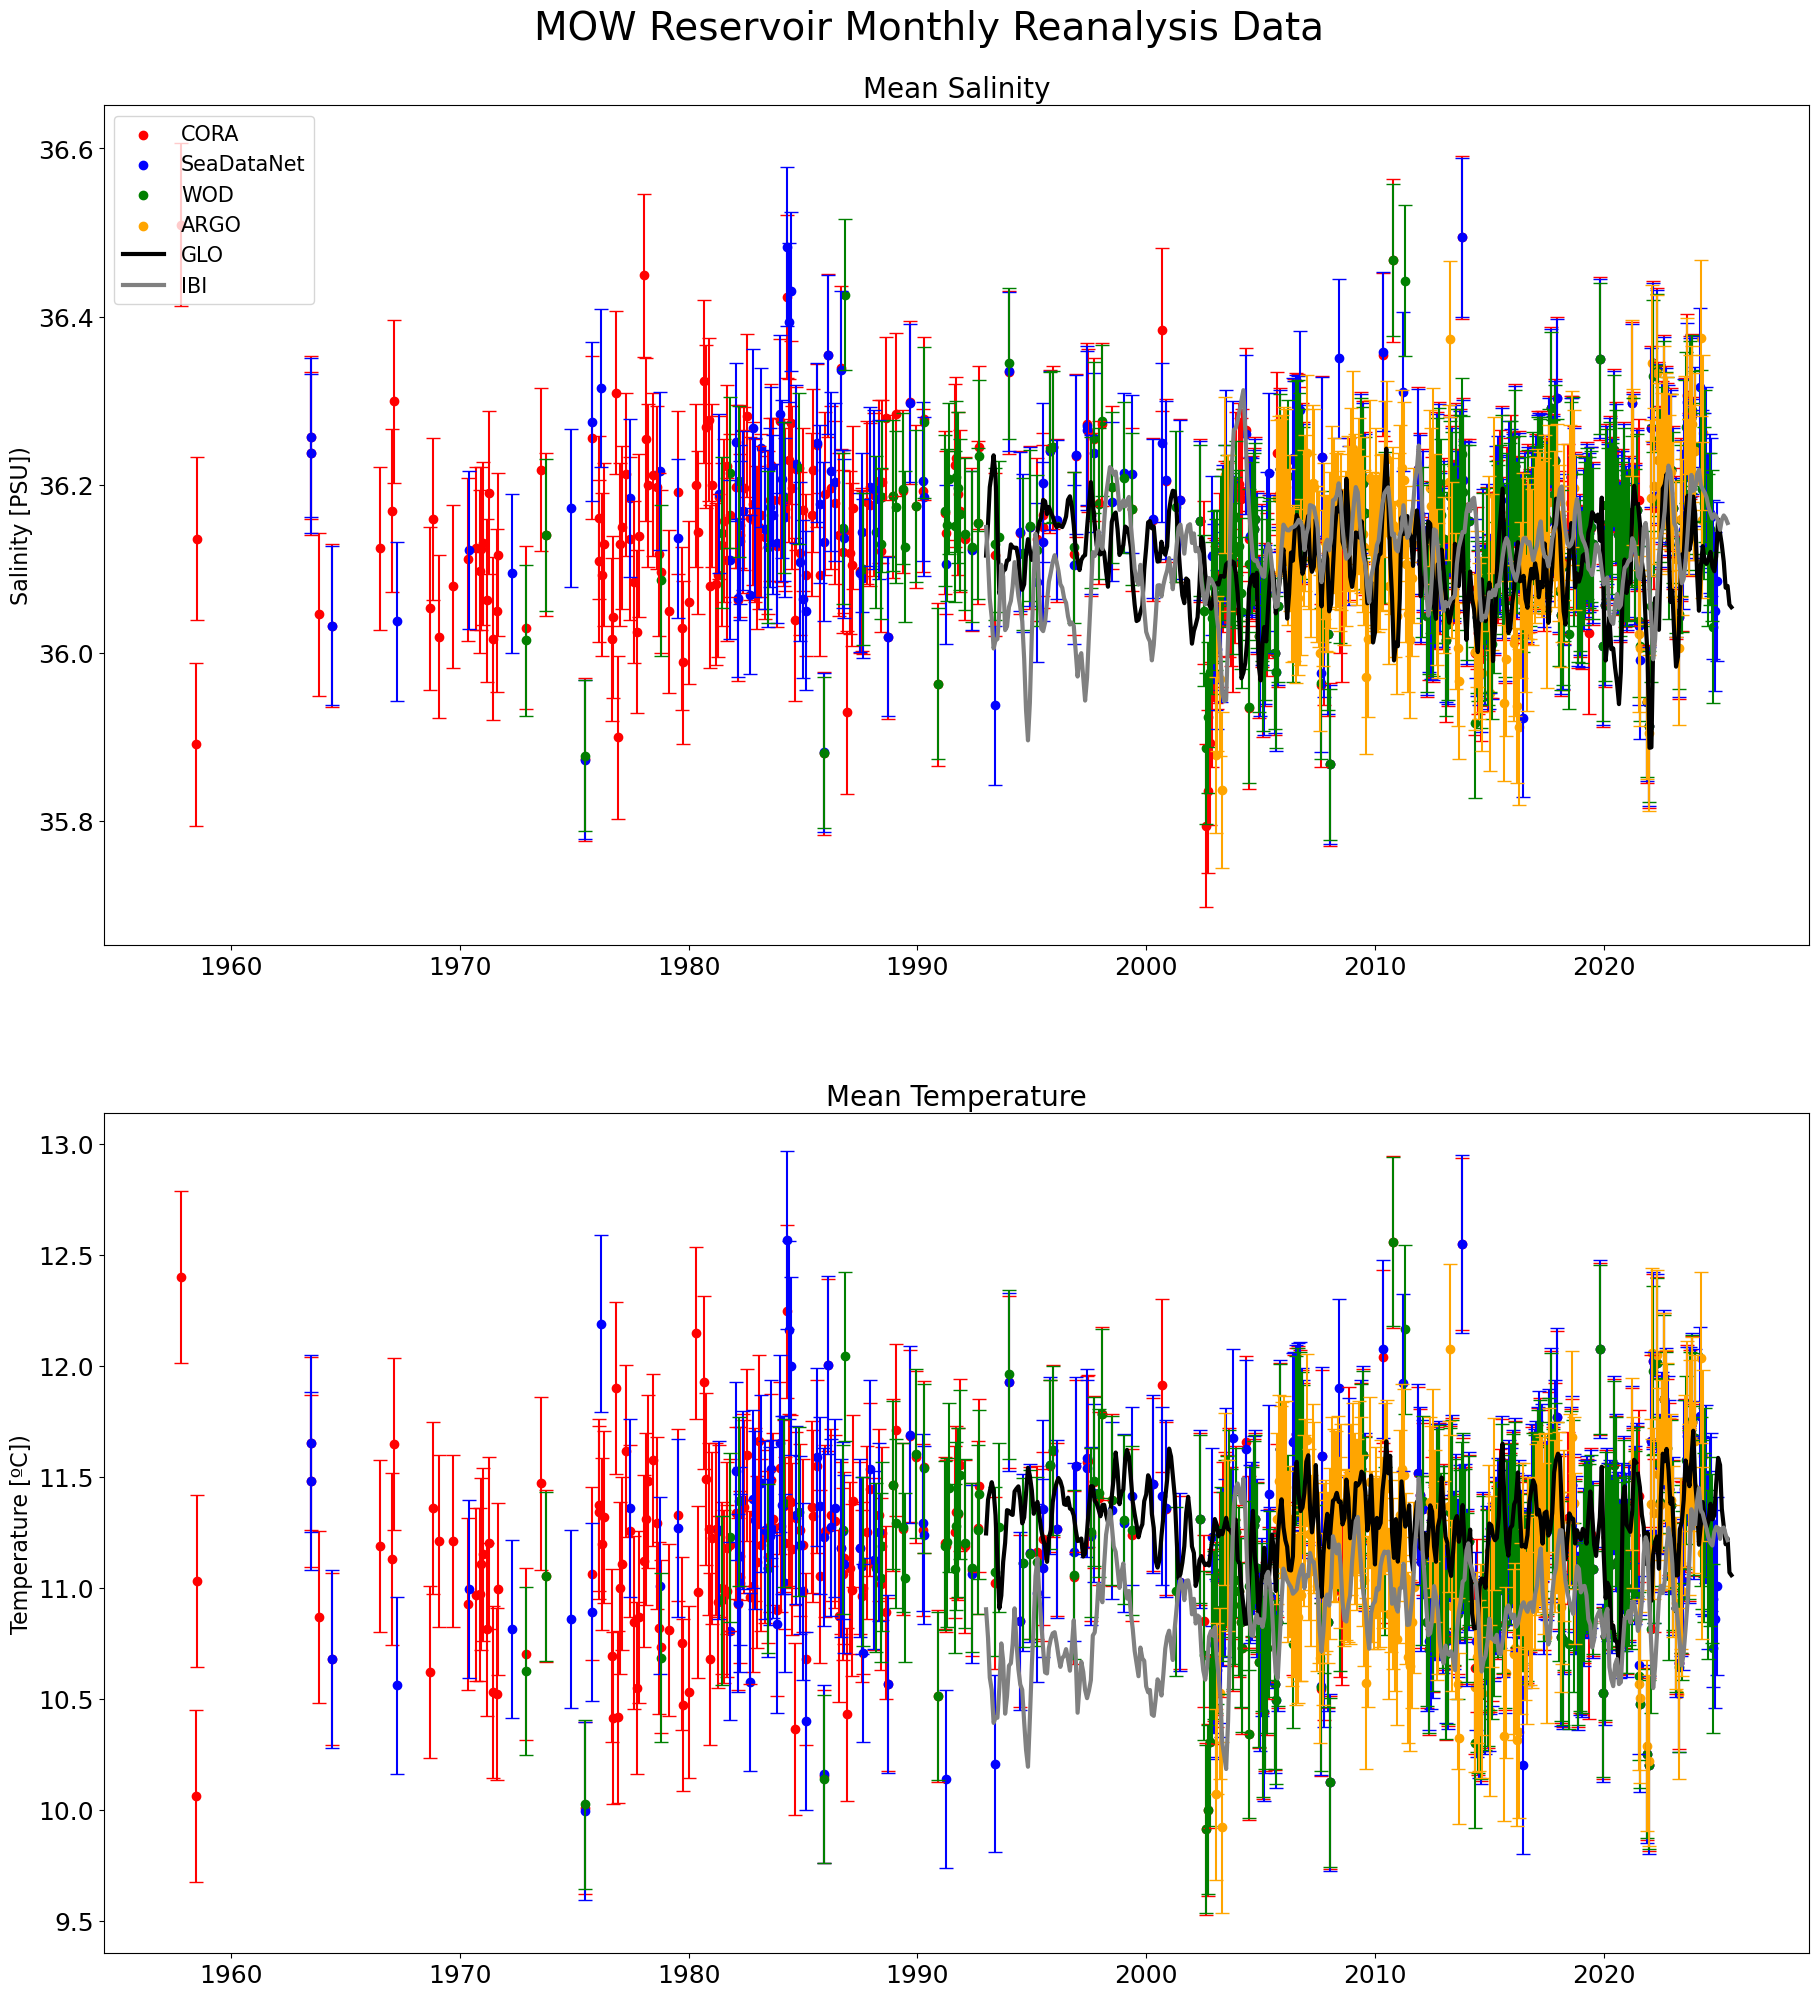

In [69]:
fig = plt.figure(figsize=[22,24])
fig.suptitle("MOW Reservoir Monthly Reanalysis Data", fontsize = 28, y = 0.92)

ax1 = fig.add_subplot(2,1,1)
ax1.scatter(CORA_month['date2'], CORA_month['sal'], color = 'r', label = "CORA")
ax1.scatter(SDN_month['date2'],SDN_month['sal'], color = 'b', label = "SeaDataNet")
ax1.scatter(WOD_month['date2'],WOD_month['sal'], color = 'g', label = "WOD")
ax1.scatter(ARGO_month['date2'],ARGO_month['sal'], color = 'orange', label = "ARGO")
ax1.errorbar(cora_m_time, CORA_month['sal'], yerr=np.std(CORA_month['sal']), color = 'r', capsize=5, ls='none')
ax1.errorbar(sdn_m_time,SDN_month['sal'], yerr=np.std(SDN_month['sal']), color = 'b', capsize=5, ls='none')
ax1.errorbar(wod_m_time,WOD_month['sal'], yerr=np.std(WOD_month['sal']), color = 'g', capsize=5, ls='none')
ax1.errorbar(argo_m_time,ARGO_month['sal'], yerr=np.std(ARGO_month['sal']), color = 'orange', capsize=5, ls='none')
ax1.plot(GLO_rean_ds['time'],GLO_sal_rean_subset1, color = 'k', lw = 3)
ax1.plot(GLO_int_ds['time'],GLO_sal_int_subset1, color = 'k', label = 'GLO', lw = 3)
ax1.plot(IBI_rean_ds['time'],IBI_sal_rean_subset1, color = 'gray', lw = 3)
ax1.plot(IBI_int_ds['time'],IBI_sal_int_subset1, color = 'gray', label = 'IBI', lw = 3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax1.set_title('Mean Salinity', fontsize = 20)
ax1.set_ylabel("Salinity [PSU])", color= 'k', fontsize=16)
ax1.legend(loc=2, prop={'size': 15})

ax1 = fig.add_subplot(2,1,2)
ax1.scatter(CORA_month['date2'], CORA_month['temp'], color = 'r', label = "CORA")
ax1.scatter(SDN_month['date2'],SDN_month['temp'], color = 'b', label = "SeaDataNet")
ax1.scatter(WOD_month['date2'],WOD_month['temp'], color = 'g', label = "WOD")
ax1.scatter(ARGO_month['date2'],ARGO_month['temp'], color = 'orange', label = "ARGO")
ax1.errorbar(cora_m_time, CORA_month['temp'], yerr=np.std(CORA_month['temp']), color = 'r', capsize=5, ls='none')
ax1.errorbar(sdn_m_time,SDN_month['temp'], yerr=np.std(SDN_month['temp']), color = 'b', capsize=5, ls='none')
ax1.errorbar(wod_m_time,WOD_month['temp'], yerr=np.std(WOD_month['temp']), color = 'g', capsize=5, ls='none')
ax1.errorbar(argo_m_time,ARGO_month['temp'], yerr=np.std(ARGO_month['temp']), color = 'orange', capsize=5, ls='none')
ax1.plot(GLO_rean_ds['time'],GLO_temp_rean_subset1, color = 'k', lw = 3)
ax1.plot(GLO_int_ds['time'],GLO_temp_int_subset1, color = 'k', label = 'GLO', lw = 3)
ax1.plot(IBI_rean_ds['time'],IBI_temp_rean_subset1, color = 'gray', lw = 3)
ax1.plot(IBI_int_ds['time'],IBI_temp_int_subset1, color = 'gray', label = 'IBI', lw = 3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax1.set_title('Mean Temperature', fontsize = 20)
ax1.set_ylabel("Temperature [ºC])", color= 'k', fontsize=16)
#ax1.legend(loc=2, prop={'size': 15})

plt.show()

#plt.savefig('./Reanal.png', format = 'png', dpi = 300)
#plt.close()